In [47]:
epochs = 20

# 데이터셋 불러오기

In [15]:
!pip install pydicom

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [3]:
root = '/root'

In [4]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [5]:
data_label = ['quarter_1mm', 'full_1mm']

In [6]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [7]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [8]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [9]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [10]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [11]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [12]:
# 파일 경로 설정
folder_name = f'{root}/dataset/'
train_path = folder_name+'train_dataset.pt'
val_path = folder_name+'val_dataset.pt'
test_path = folder_name+'test_dataset.pt'

# 데이터셋 불러오기
test_dataset = torch.load(test_path) # , weights_only=False

In [13]:
batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [14]:
len(test_loader)

6025

In [38]:
root = '/root'

# 1. REDCNN

In [18]:
%cd /root/base

/root/base


In [19]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))

        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결

        return x

In [ ]:
!pwd

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'redcnn_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNN().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")

In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# from tqdm import tqdm

# criterion = nn.MSELoss()
# interval = 1000

# # 저장된 모델 로드
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RedCNN().to(device)
# model.load_state_dict(torch.load(f'redcnn_{epochs}.pth'))

# # 평가 지표 계산 추가
# def calculate_psnr(y_true, y_pred):
#     """PSNR 계산 함수"""
#     y_true = y_true.cpu().numpy()
#     y_pred = y_pred.cpu().numpy()
#     return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# def calculate_ssim(y_true, y_pred):
#     """SSIM 계산 함수"""
#     y_true = y_true.squeeze(0).cpu().numpy()
#     y_pred = y_pred.squeeze(0).cpu().numpy()
#     return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# # evaluate 부분 + top10 best&worst
# model.eval()
# running_loss = 0.0
# running_psnr = 0.0
# running_ssim = 0.0
# psnr_list = []
# ssim_list = []
# loss_list = []
# total_loss = 0
# best_loss = np.inf
# worst_loss = -np.inf

# with torch.no_grad():
#     for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
#         X, y = data[0].to(device), data[1].to(device)
#         X_hat = model(X)
#         mse_loss = criterion(X_hat, y)

#         # RMSE 계산
#         rms_loss = torch.sqrt(mse_loss)
#         running_loss += rms_loss.item()

#         # PSNR, SSIM 계산
#         for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
#             psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
#             ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
#             running_psnr += psnr # batch에 대해 더해준다.
#             running_ssim += ssim

#         if mse_loss < best_loss:
#             best_loss = mse_loss
#             best = (X, y, X_hat)
#         if mse_loss > worst_loss:
#             worst_loss = mse_loss
#             worst = (X, y, X_hat)

#         if i % interval == interval - 1:
#             interval_loss = running_loss / interval
#             interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
#             interval_ssim = running_ssim / (interval * X.size(0))

#             loss_list.append(interval_loss)
#             psnr_list.append(interval_psnr)
#             ssim_list.append(interval_ssim)

#             total_loss += interval_loss
#             running_loss = 0.0
#             running_psnr = 0.0
#             running_ssim = 0.0
#             tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
#             # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

#     # 평균 RMSE 출력
# average_loss = total_loss / len(loss_list)
# print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1003/6025 [00:38<03:10, 26.29it/s]

RMSE per interval: 0.0470, PSNR per interval: 27.37, SSIM per interval: 0.6766


Evaluating:  33%|███▎      | 2003/6025 [01:17<02:30, 26.79it/s]

RMSE per interval: 0.0439, PSNR per interval: 28.13, SSIM per interval: 0.6889


Evaluating:  50%|████▉     | 3005/6025 [01:55<01:50, 27.27it/s]

RMSE per interval: 0.0446, PSNR per interval: 28.21, SSIM per interval: 0.6949


Evaluating:  66%|██████▋   | 4003/6025 [02:33<01:19, 25.57it/s]

RMSE per interval: 0.0389, PSNR per interval: 29.06, SSIM per interval: 0.7177


Evaluating:  83%|████████▎ | 5003/6025 [03:12<00:38, 26.28it/s]

RMSE per interval: 0.0384, PSNR per interval: 29.14, SSIM per interval: 0.6919


Evaluating: 100%|█████████▉| 6004/6025 [03:50<00:00, 31.51it/s]

RMSE per interval: 0.0357, PSNR per interval: 29.96, SSIM per interval: 0.7395


Evaluating: 100%|██████████| 6025/6025 [03:51<00:00, 26.05it/s]

Average RMSE over all intervals: 0.041404


In [26]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [27]:
rmse_list = loss_list
rmse_list

[0.04695483331941068,
 0.043945035506039856,
 0.0445557337263599,
 0.038896427400410175,
 0.038351357743144035,
 0.035719020100310445]

In [28]:
!pwd

/root/base


In [ ]:
# # 저장하는 코드

# import pandas as pd

# # 데이터프레임 생성
# df = pd.DataFrame({
#     "RMSE": loss_list,
#     "PSNR": psnr_list,
#     "SSIM": ssim_list
# })

# # CSV 파일 저장
# csv_filename = f"{root}/base/results.csv"
# df.to_csv(csv_filename, index=False)

# print(f"저장 완료: {csv_filename}")

저장 완료: /root/base/results.csv


In [ ]:
# # 불러오는 코드

# import pandas as pd

# # CSV 파일 불러오기
# csv_filename = f"{root}/base/results.csv"
# df = pd.read_csv(csv_filename)

# # 불러온 데이터 출력
# print(df,'\n')

# # 개별 리스트로 변환
# loss_list = df["RMSE"].tolist()
# psnr_list = df["PSNR"].tolist()
# ssim_list = df["SSIM"].tolist()

# # 확인 출력
# print("RMSE List:", loss_list)
# print("PSNR List:", psnr_list)
# print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046955  27.371000  0.676597
1  0.043945  28.134906  0.688910
2  0.044556  28.206019  0.694916
3  0.038896  29.056226  0.717701
4  0.038351  29.143702  0.691895
5  0.035719  29.962605  0.739510 

RMSE List: [0.0469548333194106, 0.0439450355060398, 0.0445557337263599, 0.0388964274004101, 0.038351357743144, 0.0357190201003104]
PSNR List: [27.371000108446708, 28.13490557974061, 28.206018557433744, 29.05622569361948, 29.14370227522719, 29.962604834715552]
SSIM List: [0.676596938518149, 0.6889095985207111, 0.6949160609136568, 0.7177008078848243, 0.6918946477055753, 0.7395095056443397]


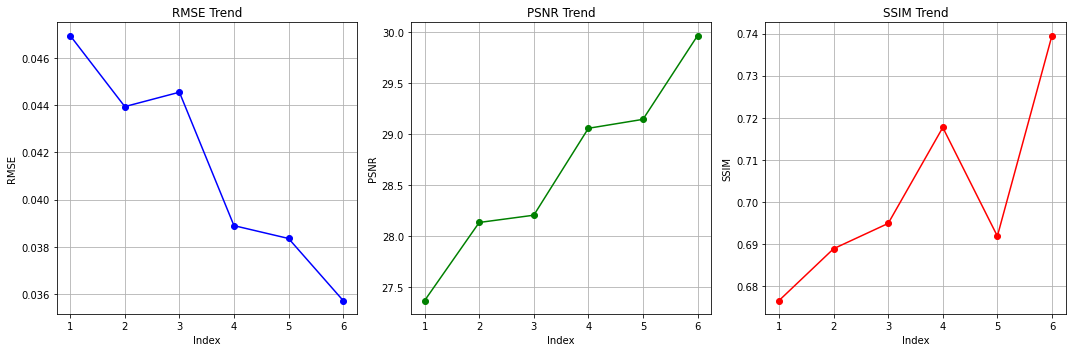

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 그래프 인덱스 (각 값의 순서를 나타냄)
# x_values = np.arange(1, 7)

# # 그래프 그리기
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# # RMSE 그래프
# axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
# axs[0].set_title('RMSE Trend')
# axs[0].set_xlabel('Index')
# axs[0].set_ylabel('RMSE')
# axs[0].grid(True)

# # PSNR 그래프
# axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
# axs[1].set_title('PSNR Trend')
# axs[1].set_xlabel('Index')
# axs[1].set_ylabel('PSNR')
# axs[1].grid(True)

# # SSIM 그래프
# axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
# axs[2].set_title('SSIM Trend')
# axs[2].set_xlabel('Index')
# axs[2].set_ylabel('SSIM')
# axs[2].grid(True)

# # 그래프 레이아웃 조정 및 표시
# plt.tight_layout()
# plt.show()

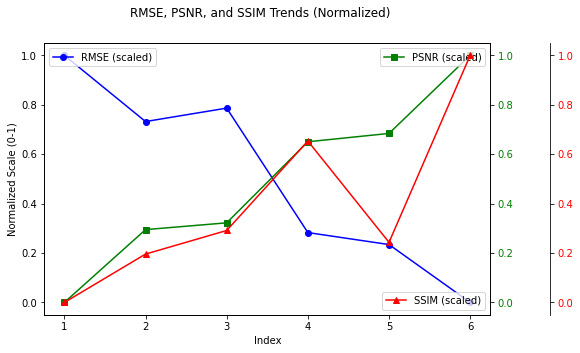

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 정규화 함수 (min-max scaling)
# def min_max_scale(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))

# # 정규화
# rmse_scaled = min_max_scale(rmse_list)
# psnr_scaled = min_max_scale(psnr_list)
# ssim_scaled = min_max_scale(ssim_list)

# # 그래프 인덱스
# x_values = np.arange(1, len(rmse_list) + 1)

# # 그래프 그리기
# fig, ax1 = plt.subplots(figsize=(8, 5))

# # RMSE (파란색 원)
# ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
# ax1.set_ylabel("Normalized Scale (0-1)", color='black')
# ax1.set_xlabel("Index")
# ax1.tick_params(axis='y', labelcolor='black')

# # PSNR (초록색 사각형, 보조 y축)
# ax2 = ax1.twinx()
# ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
# ax2.tick_params(axis='y', labelcolor='g')

# # SSIM (빨간색 삼각형, 추가 y축)
# ax3 = ax1.twinx()
# ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
# ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
# ax3.tick_params(axis='y', labelcolor='r')

# # 제목 및 범례
# fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
# ax3.legend(loc="lower right")

# # 그래프 표시
# plt.show()

In [ ]:
# # 평균(mean)과 표준편차(sd) 계산
# rmse_mean = np.mean(rmse_list)
# rmse_sd = np.std(rmse_list)

# psnr_mean = np.mean(psnr_list)
# psnr_sd = np.std(psnr_list)

# ssim_mean = np.mean(ssim_list)
# ssim_sd = np.std(ssim_list)

# # 결과를 mean ± sd 형식으로 표현
# rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
# psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
# ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# # 결과 출력
# print(f"RMSE: {rmse_result}")
# print(f"PSNR: {psnr_result}")
# print(f"SSIM: {ssim_result}")

RMSE: 0.0414 ± 0.0040
PSNR: 28.6457 ± 0.8396
SSIM: 0.7016 ± 0.0209


# 1-2. REDCNN with C.A.

In [35]:
%cd {root}/attention_channel

/root/attention_channel


In [ ]:
!pwd

In [36]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [37]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
        self.last_attention = None  # 저장된 Attention 값을 위한 변수

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # 채널별 전역 평균 풀링
        y = self.avg_pool(x).view(batch, channels)
        y = self.fc(y).view(batch, channels, 1, 1)
        self.last_attention = y  # 계산된 Attention Weight 저장
        return x * y

In [38]:
class RedCNNWithChannelAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithChannelAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Attention Blocks (효율적 배치)
        self.attention2 = SEBlock(96)  # 중간 계층
        self.attention3 = SEBlock(96)  # 고수준 특징 계층

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.attention2(x)  # 중간 계층에 Attention
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.attention3(x)  # 최종 인코더 계층에 Attention

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [ ]:
!pwd

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'red_cnn_C_A_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNNWithChannelAttention().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")

In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# from tqdm import tqdm

# criterion = nn.MSELoss()
# interval = 1000

# # 저장된 모델 로드
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RedCNNWithChannelAttention().to(device)
# model.load_state_dict(torch.load(f'red_cnn_C_A_{epochs}.pth'))

# # 평가 지표 계산 추가
# def calculate_psnr(y_true, y_pred):
#     """PSNR 계산 함수"""
#     y_true = y_true.cpu().numpy()
#     y_pred = y_pred.cpu().numpy()
#     return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# def calculate_ssim(y_true, y_pred):
#     """SSIM 계산 함수"""
#     y_true = y_true.squeeze(0).cpu().numpy()
#     y_pred = y_pred.squeeze(0).cpu().numpy()
#     return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# # evaluate 부분 + top10 best&worst
# model.eval()
# running_loss = 0.0
# running_psnr = 0.0
# running_ssim = 0.0
# psnr_list = []
# ssim_list = []
# loss_list = []
# total_loss = 0
# best_loss = np.inf
# worst_loss = -np.inf

# with torch.no_grad():
#     for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
#         X, y = data[0].to(device), data[1].to(device)
#         X_hat = model(X)
#         mse_loss = criterion(X_hat, y)

#         # RMSE 계산
#         rms_loss = torch.sqrt(mse_loss)
#         running_loss += rms_loss.item()

#         # PSNR, SSIM 계산
#         for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
#             psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
#             ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
#             running_psnr += psnr # batch에 대해 더해준다.
#             running_ssim += ssim

#         if mse_loss < best_loss:
#             best_loss = mse_loss
#             best = (X, y, X_hat)
#         if mse_loss > worst_loss:
#             worst_loss = mse_loss
#             worst = (X, y, X_hat)

#         if i % interval == interval - 1:
#             interval_loss = running_loss / interval
#             interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
#             interval_ssim = running_ssim / (interval * X.size(0))

#             loss_list.append(interval_loss)
#             psnr_list.append(interval_psnr)
#             ssim_list.append(interval_ssim)

#             total_loss += interval_loss
#             running_loss = 0.0
#             running_psnr = 0.0
#             running_ssim = 0.0
#             tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
#             # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

#     # 평균 RMSE 출력
# average_loss = total_loss / len(loss_list)
# print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1003/6025 [00:38<03:12, 26.05it/s]

RMSE per interval: 0.0466, PSNR per interval: 27.46, SSIM per interval: 0.6737


Evaluating:  33%|███▎      | 2003/6025 [01:17<02:25, 27.56it/s]

RMSE per interval: 0.0441, PSNR per interval: 28.21, SSIM per interval: 0.6897


Evaluating:  50%|████▉     | 3004/6025 [01:55<02:04, 24.35it/s]

RMSE per interval: 0.0445, PSNR per interval: 28.29, SSIM per interval: 0.6989


Evaluating:  66%|██████▋   | 4003/6025 [02:34<01:19, 25.31it/s]

RMSE per interval: 0.0381, PSNR per interval: 29.33, SSIM per interval: 0.7244


Evaluating:  83%|████████▎ | 5003/6025 [03:13<00:38, 26.25it/s]

RMSE per interval: 0.0377, PSNR per interval: 29.41, SSIM per interval: 0.7035


Evaluating: 100%|█████████▉| 6005/6025 [03:52<00:00, 25.95it/s]

RMSE per interval: 0.0358, PSNR per interval: 30.10, SSIM per interval: 0.7458


Evaluating: 100%|██████████| 6025/6025 [03:53<00:00, 25.82it/s]

Average RMSE over all intervals: 0.041131


In [ ]:
# len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [ ]:
# rmse_list = loss_list
# rmse_list

[0.04663510580547154,
 0.044072548963129524,
 0.044531345320865515,
 0.03807630428299308,
 0.037717219656333324,
 0.03575627517234534]

In [ ]:
# !pwd

/root/attention_channel


In [ ]:
# # 저장하는 코드

# import pandas as pd

# # 데이터프레임 생성
# df = pd.DataFrame({
#     "RMSE": loss_list,
#     "PSNR": psnr_list,
#     "SSIM": ssim_list
# })

# # CSV 파일 저장
# csv_filename = f"{root}/attention_channel/results.csv"
# df.to_csv(csv_filename, index=False)

# print(f"저장 완료: {csv_filename}")

저장 완료: /root/attention_channel/results.csv


In [ ]:
# # 불러오는 코드

# import pandas as pd

# # CSV 파일 불러오기
# csv_filename = f"{root}/attention_channel/results.csv"
# df = pd.read_csv(csv_filename)

# # 불러온 데이터 출력
# print(df,'\n')

# # 개별 리스트로 변환
# loss_list = df["RMSE"].tolist()
# psnr_list = df["PSNR"].tolist()
# ssim_list = df["SSIM"].tolist()

# # 확인 출력
# print("RMSE List:", loss_list)
# print("PSNR List:", psnr_list)
# print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046635  27.461906  0.673734
1  0.044073  28.206451  0.689694
2  0.044531  28.287235  0.698862
3  0.038076  29.325519  0.724371
4  0.037717  29.412435  0.703514
5  0.035756  30.100435  0.745796 

RMSE List: [0.0466351058054715, 0.0440725489631295, 0.0445313453208655, 0.038076304282993, 0.0377172196563333, 0.0357562751723453]
PSNR List: [27.46190600340232, 28.20645137517561, 28.28723539238857, 29.325518967436206, 29.41243535479707, 30.100435310031525]
SSIM List: [0.6737339476550062, 0.6896936758362453, 0.6988624186332398, 0.7243705423738875, 0.7035141124539104, 0.745796373968237]


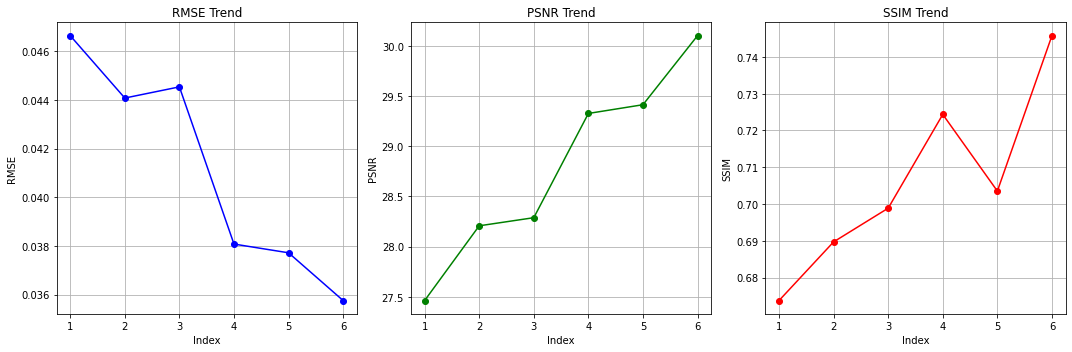

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 그래프 인덱스 (각 값의 순서를 나타냄)
# x_values = np.arange(1, 7)

# # 그래프 그리기
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# # RMSE 그래프
# axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
# axs[0].set_title('RMSE Trend')
# axs[0].set_xlabel('Index')
# axs[0].set_ylabel('RMSE')
# axs[0].grid(True)

# # PSNR 그래프
# axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
# axs[1].set_title('PSNR Trend')
# axs[1].set_xlabel('Index')
# axs[1].set_ylabel('PSNR')
# axs[1].grid(True)

# # SSIM 그래프
# axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
# axs[2].set_title('SSIM Trend')
# axs[2].set_xlabel('Index')
# axs[2].set_ylabel('SSIM')
# axs[2].grid(True)

# # 그래프 레이아웃 조정 및 표시
# plt.tight_layout()
# plt.show()

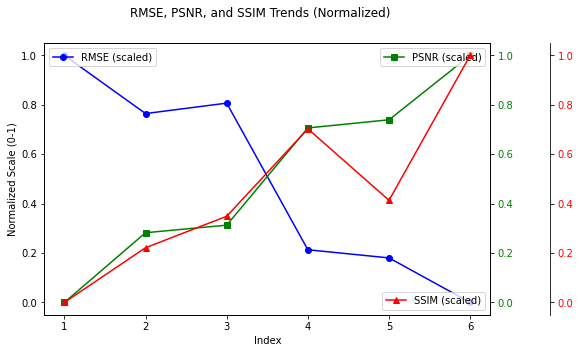

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 정규화 함수 (min-max scaling)
# def min_max_scale(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))

# # 정규화
# rmse_scaled = min_max_scale(rmse_list)
# psnr_scaled = min_max_scale(psnr_list)
# ssim_scaled = min_max_scale(ssim_list)

# # 그래프 인덱스
# x_values = np.arange(1, len(rmse_list) + 1)

# # 그래프 그리기
# fig, ax1 = plt.subplots(figsize=(8, 5))

# # RMSE (파란색 원)
# ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
# ax1.set_ylabel("Normalized Scale (0-1)", color='black')
# ax1.set_xlabel("Index")
# ax1.tick_params(axis='y', labelcolor='black')

# # PSNR (초록색 사각형, 보조 y축)
# ax2 = ax1.twinx()
# ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
# ax2.tick_params(axis='y', labelcolor='g')

# # SSIM (빨간색 삼각형, 추가 y축)
# ax3 = ax1.twinx()
# ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
# ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
# ax3.tick_params(axis='y', labelcolor='r')

# # 제목 및 범례
# fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
# ax3.legend(loc="lower right")

# # 그래프 표시
# plt.show()

In [ ]:
# # 평균(mean)과 표준편차(sd) 계산
# rmse_mean = np.mean(rmse_list)
# rmse_sd = np.std(rmse_list)

# psnr_mean = np.mean(psnr_list)
# psnr_sd = np.std(psnr_list)

# ssim_mean = np.mean(ssim_list)
# ssim_sd = np.std(ssim_list)

# # 결과를 mean ± sd 형식으로 표현
# rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
# psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
# ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# # 결과 출력
# print(f"RMSE: {rmse_result}")
# print(f"PSNR: {psnr_result}")
# print(f"SSIM: {ssim_result}")

RMSE: 0.0411 ± 0.0041
PSNR: 28.7990 ± 0.8896
SSIM: 0.7060 ± 0.0234


# 1-3. REDCNN with S.A.

In [40]:
%cd {root}/attention_spatial/

/root/attention_spatial


In [41]:
pwd

'/root/attention_spatial'

In [42]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [43]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2 # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x):
        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True) # Average pooling
        max_out, _ = torch.max(x, dim=1, keepdim=True) # Max pooling
        combined = torch.cat([avg_out, max_out], dim=1) # 채널 차원에서 결합
        # 2D Convolution 적용
        attention = self.sigmoid(self.conv(combined)) # [B, 1, H, W]
        self.last_attention = attention  # Attention 값을 저장
        return x * attention

In [44]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [45]:
!pwd

/root/attention_spatial


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'red_cnn_S_A_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNNWithSpatialAttention().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")


Evaluating Model at Epoch 1


Evaluating Epoch 1:  17%|█▋        | 1007/6025 [00:17<01:27, 57.60it/s]

[Epoch 1] RMSE per interval: 0.0463, PSNR per interval: 27.52, SSIM per interval: 0.6728


Evaluating Epoch 1:  33%|███▎      | 2008/6025 [00:34<01:08, 58.54it/s]

[Epoch 1] RMSE per interval: 0.0437, PSNR per interval: 28.31, SSIM per interval: 0.6881


Evaluating Epoch 1:  50%|████▉     | 3009/6025 [00:52<00:51, 59.09it/s]

[Epoch 1] RMSE per interval: 0.0440, PSNR per interval: 28.45, SSIM per interval: 0.6966


Evaluating Epoch 1:  67%|██████▋   | 4010/6025 [01:09<00:33, 59.49it/s]

[Epoch 1] RMSE per interval: 0.0376, PSNR per interval: 29.44, SSIM per interval: 0.7237


Evaluating Epoch 1:  83%|████████▎ | 5010/6025 [01:26<00:17, 59.35it/s]

[Epoch 1] RMSE per interval: 0.0372, PSNR per interval: 29.55, SSIM per interval: 0.7033


Evaluating Epoch 1: 100%|█████████▉| 6009/6025 [01:43<00:00, 54.85it/s]

[Epoch 1] RMSE per interval: 0.0353, PSNR per interval: 30.26, SSIM per interval: 0.7459


Evaluating Epoch 1: 100%|██████████| 6025/6025 [01:44<00:00, 57.77it/s]

[Epoch 1] Average RMSE over all intervals: 0.040684
[Epoch 1] 저장 완료: results_1.csv

Evaluating Model at Epoch 5



Evaluating Epoch 5:  17%|█▋        | 1006/6025 [00:17<01:26, 57.75it/s]

[Epoch 5] RMSE per interval: 0.0444, PSNR per interval: 27.90, SSIM per interval: 0.6828


Evaluating Epoch 5:  33%|███▎      | 2009/6025 [00:34<01:10, 57.33it/s]

[Epoch 5] RMSE per interval: 0.0418, PSNR per interval: 28.72, SSIM per interval: 0.6999


Evaluating Epoch 5:  50%|████▉     | 3005/6025 [00:51<00:52, 57.38it/s]

[Epoch 5] RMSE per interval: 0.0419, PSNR per interval: 28.92, SSIM per interval: 0.7099


Evaluating Epoch 5:  67%|██████▋   | 4010/6025 [01:09<00:37, 53.61it/s]

[Epoch 5] RMSE per interval: 0.0359, PSNR per interval: 29.86, SSIM per interval: 0.7353


Evaluating Epoch 5:  83%|████████▎ | 5007/6025 [01:26<00:17, 58.54it/s]

[Epoch 5] RMSE per interval: 0.0356, PSNR per interval: 29.96, SSIM per interval: 0.7124


Evaluating Epoch 5: 100%|█████████▉| 6009/6025 [01:46<00:00, 49.71it/s]

[Epoch 5] RMSE per interval: 0.0334, PSNR per interval: 30.75, SSIM per interval: 0.7561


Evaluating Epoch 5: 100%|██████████| 6025/6025 [01:47<00:00, 56.28it/s]

[Epoch 5] Average RMSE over all intervals: 0.038831
[Epoch 5] 저장 완료: results_5.csv

Evaluating Model at Epoch 10



Evaluating Epoch 10:  17%|█▋        | 1010/6025 [00:20<01:40, 49.79it/s]

[Epoch 10] RMSE per interval: 0.0440, PSNR per interval: 27.98, SSIM per interval: 0.6846


Evaluating Epoch 10:  33%|███▎      | 2008/6025 [00:40<01:19, 50.70it/s]

[Epoch 10] RMSE per interval: 0.0414, PSNR per interval: 28.81, SSIM per interval: 0.7021


Evaluating Epoch 10:  50%|████▉     | 3008/6025 [00:59<00:52, 57.17it/s]

[Epoch 10] RMSE per interval: 0.0414, PSNR per interval: 29.01, SSIM per interval: 0.7117


Evaluating Epoch 10:  67%|██████▋   | 4011/6025 [01:16<00:33, 60.26it/s]

[Epoch 10] RMSE per interval: 0.0355, PSNR per interval: 29.95, SSIM per interval: 0.7375


Evaluating Epoch 10:  83%|████████▎ | 5008/6025 [01:33<00:16, 60.84it/s]

[Epoch 10] RMSE per interval: 0.0352, PSNR per interval: 30.05, SSIM per interval: 0.7145


Evaluating Epoch 10: 100%|█████████▉| 6009/6025 [01:51<00:00, 57.17it/s]

[Epoch 10] RMSE per interval: 0.0330, PSNR per interval: 30.84, SSIM per interval: 0.7583


Evaluating Epoch 10: 100%|██████████| 6025/6025 [01:51<00:00, 54.00it/s]

[Epoch 10] Average RMSE over all intervals: 0.038431
[Epoch 10] 저장 완료: results_10.csv

Evaluating Model at Epoch 20



Evaluating Epoch 20:  17%|█▋        | 1005/6025 [00:17<01:23, 60.03it/s]

[Epoch 20] RMSE per interval: 0.0435, PSNR per interval: 28.08, SSIM per interval: 0.6800


Evaluating Epoch 20:  33%|███▎      | 2010/6025 [00:34<01:08, 58.52it/s]

[Epoch 20] RMSE per interval: 0.0412, PSNR per interval: 28.87, SSIM per interval: 0.6979


Evaluating Epoch 20:  50%|████▉     | 3006/6025 [00:51<00:50, 59.41it/s]

[Epoch 20] RMSE per interval: 0.0411, PSNR per interval: 29.08, SSIM per interval: 0.7072


Evaluating Epoch 20:  67%|██████▋   | 4010/6025 [01:09<00:34, 57.59it/s]

[Epoch 20] RMSE per interval: 0.0351, PSNR per interval: 30.05, SSIM per interval: 0.7353


Evaluating Epoch 20:  83%|████████▎ | 5009/6025 [01:26<00:17, 57.21it/s]

[Epoch 20] RMSE per interval: 0.0350, PSNR per interval: 30.12, SSIM per interval: 0.7121


Evaluating Epoch 20: 100%|█████████▉| 6005/6025 [01:43<00:00, 55.72it/s]

[Epoch 20] RMSE per interval: 0.0328, PSNR per interval: 30.89, SSIM per interval: 0.7552


Evaluating Epoch 20: 100%|██████████| 6025/6025 [01:44<00:00, 57.88it/s]

[Epoch 20] Average RMSE over all intervals: 0.038105
[Epoch 20] 저장 완료: results_20.csv
[Epoch 30] 모델 파일이 존재하지 않습니다. 건너뜁니다.


In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# from tqdm import tqdm

# criterion = nn.MSELoss()
# interval = 1000

# # 저장된 모델 로드
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RedCNNWithSpatialAttention().to(device)
# model.load_state_dict(torch.load(f'red_cnn_S_A_{epochs}.pth'))

# # 평가 지표 계산 추가
# def calculate_psnr(y_true, y_pred):
#     """PSNR 계산 함수"""
#     y_true = y_true.cpu().numpy()
#     y_pred = y_pred.cpu().numpy()
#     return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# def calculate_ssim(y_true, y_pred):
#     """SSIM 계산 함수"""
#     y_true = y_true.squeeze(0).cpu().numpy()
#     y_pred = y_pred.squeeze(0).cpu().numpy()
#     return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# # evaluate 부분 + top10 best&worst
# model.eval()
# running_loss = 0.0
# running_psnr = 0.0
# running_ssim = 0.0
# psnr_list = []
# ssim_list = []
# loss_list = []
# total_loss = 0
# best_loss = np.inf
# worst_loss = -np.inf

# with torch.no_grad():
#     for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
#         X, y = data[0].to(device), data[1].to(device)
#         X_hat = model(X)
#         mse_loss = criterion(X_hat, y)

#         # RMSE 계산
#         rms_loss = torch.sqrt(mse_loss)
#         running_loss += rms_loss.item()

#         # PSNR, SSIM 계산
#         for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
#             psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
#             ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
#             running_psnr += psnr # batch에 대해 더해준다.
#             running_ssim += ssim

#         if mse_loss < best_loss:
#             best_loss = mse_loss
#             best = (X, y, X_hat)
#         if mse_loss > worst_loss:
#             worst_loss = mse_loss
#             worst = (X, y, X_hat)

#         if i % interval == interval - 1:
#             interval_loss = running_loss / interval
#             interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
#             interval_ssim = running_ssim / (interval * X.size(0))

#             loss_list.append(interval_loss)
#             psnr_list.append(interval_psnr)
#             ssim_list.append(interval_ssim)

#             total_loss += interval_loss
#             running_loss = 0.0
#             running_psnr = 0.0
#             running_ssim = 0.0
#             tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
#             # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

#     # 평균 RMSE 출력
# average_loss = total_loss / len(loss_list)
# print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1003/6025 [00:32<02:31, 33.18it/s]

RMSE per interval: 0.0434, PSNR per interval: 28.10, SSIM per interval: 0.6842


Evaluating:  33%|███▎      | 2005/6025 [01:02<02:07, 31.44it/s]

RMSE per interval: 0.0410, PSNR per interval: 28.90, SSIM per interval: 0.7019


Evaluating:  50%|████▉     | 3005/6025 [01:34<01:35, 31.56it/s]

RMSE per interval: 0.0409, PSNR per interval: 29.13, SSIM per interval: 0.7118


Evaluating:  66%|██████▋   | 4005/6025 [02:05<00:53, 37.73it/s]

RMSE per interval: 0.0350, PSNR per interval: 30.07, SSIM per interval: 0.7383


Evaluating:  83%|████████▎ | 5004/6025 [02:36<00:31, 32.40it/s]

RMSE per interval: 0.0349, PSNR per interval: 30.14, SSIM per interval: 0.7147


Evaluating: 100%|█████████▉| 6004/6025 [03:08<00:00, 30.47it/s]

RMSE per interval: 0.0326, PSNR per interval: 30.93, SSIM per interval: 0.7582


Evaluating: 100%|██████████| 6025/6025 [03:09<00:00, 31.78it/s]

Average RMSE over all intervals: 0.037975


In [ ]:
# len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [ ]:
# rmse_list = loss_list
# rmse_list

[0.0434246192779392,
 0.040998989977873865,
 0.04091860427707434,
 0.035001874754205346,
 0.0348738474342972,
 0.032634458534419535]

In [ ]:
# !pwd

/root/attention_spatial


In [ ]:
# # 저장하는 코드

# import pandas as pd

# # 데이터프레임 생성
# df = pd.DataFrame({
#     "RMSE": loss_list,
#     "PSNR": psnr_list,
#     "SSIM": ssim_list
# })

# # CSV 파일 저장
# csv_filename = f"{root}/attention_spatial/results.csv"
# df.to_csv(csv_filename, index=False)

# print(f"저장 완료: {csv_filename}")

저장 완료: /root/attention_spatial/results.csv


In [ ]:
# # 불러오는 코드

# import pandas as pd

# # CSV 파일 불러오기
# csv_filename = f"{root}/attention_spatial/results.csv"
# df = pd.read_csv(csv_filename)

# # 불러온 데이터 출력
# print(df,'\n')

# # 개별 리스트로 변환
# loss_list = df["RMSE"].tolist()
# psnr_list = df["PSNR"].tolist()
# ssim_list = df["SSIM"].tolist()

# # 확인 출력
# print("RMSE List:", loss_list)
# print("PSNR List:", psnr_list)
# print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.043425  28.102589  0.684205
1  0.040999  28.903337  0.701939
2  0.040919  29.126717  0.711839
3  0.035002  30.072307  0.738309
4  0.034874  30.144735  0.714661
5  0.032634  30.933748  0.758179 

RMSE List: [0.0434246192779392, 0.0409989899778738, 0.0409186042770743, 0.0350018747542053, 0.0348738474342972, 0.0326344585344195]
PSNR List: [28.10258870148757, 28.903337222949247, 29.12671727716961, 30.07230733239756, 30.144735260959887, 30.93374777042707]
SSIM List: [0.6842051089952907, 0.7019388751063982, 0.7118388545007611, 0.7383085177371773, 0.71466132965685, 0.7581789903657306]


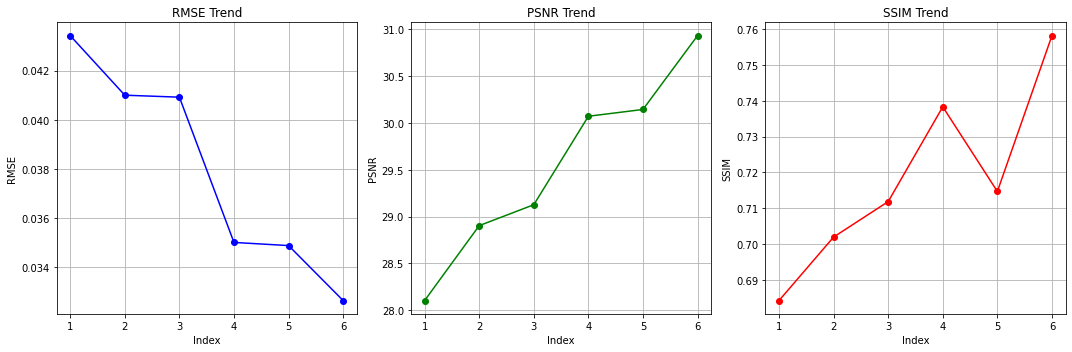

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 그래프 인덱스 (각 값의 순서를 나타냄)
# x_values = np.arange(1, 7)

# # 그래프 그리기
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# # RMSE 그래프
# axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
# axs[0].set_title('RMSE Trend')
# axs[0].set_xlabel('Index')
# axs[0].set_ylabel('RMSE')
# axs[0].grid(True)

# # PSNR 그래프
# axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
# axs[1].set_title('PSNR Trend')
# axs[1].set_xlabel('Index')
# axs[1].set_ylabel('PSNR')
# axs[1].grid(True)

# # SSIM 그래프
# axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
# axs[2].set_title('SSIM Trend')
# axs[2].set_xlabel('Index')
# axs[2].set_ylabel('SSIM')
# axs[2].grid(True)

# # 그래프 레이아웃 조정 및 표시
# plt.tight_layout()
# plt.show()

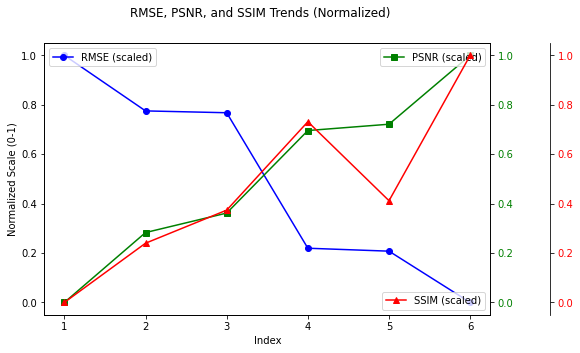

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 정규화 함수 (min-max scaling)
# def min_max_scale(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))

# # 정규화
# rmse_scaled = min_max_scale(rmse_list)
# psnr_scaled = min_max_scale(psnr_list)
# ssim_scaled = min_max_scale(ssim_list)

# # 그래프 인덱스
# x_values = np.arange(1, len(rmse_list) + 1)

# # 그래프 그리기
# fig, ax1 = plt.subplots(figsize=(8, 5))

# # RMSE (파란색 원)
# ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
# ax1.set_ylabel("Normalized Scale (0-1)", color='black')
# ax1.set_xlabel("Index")
# ax1.tick_params(axis='y', labelcolor='black')

# # PSNR (초록색 사각형, 보조 y축)
# ax2 = ax1.twinx()
# ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
# ax2.tick_params(axis='y', labelcolor='g')

# # SSIM (빨간색 삼각형, 추가 y축)
# ax3 = ax1.twinx()
# ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
# ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
# ax3.tick_params(axis='y', labelcolor='r')

# # 제목 및 범례
# fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
# ax3.legend(loc="lower right")

# # 그래프 표시
# plt.show()

In [ ]:
# # 평균(mean)과 표준편차(sd) 계산
# rmse_mean = np.mean(rmse_list)
# rmse_sd = np.std(rmse_list)

# psnr_mean = np.mean(psnr_list)
# psnr_sd = np.std(psnr_list)

# ssim_mean = np.mean(ssim_list)
# ssim_sd = np.std(ssim_list)

# # 결과를 mean ± sd 형식으로 표현
# rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
# psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
# ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# # 결과 출력
# print(f"RMSE: {rmse_result}")
# print(f"PSNR: {psnr_result}")
# print(f"SSIM: {ssim_result}")

RMSE: 0.0380 ± 0.0040
PSNR: 29.5472 ± 0.9339
SSIM: 0.7182 ± 0.0241


# 2. moanet

## 데이터셋 불러오기

In [48]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
organ_probs_df.head(1)

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,2.140607e-08,0.00043,0.978917,0.018699,0.000021,0.000003,0.000001,0.001919,2.020908e-07,0.000009,7.648957e-07


In [49]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [50]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path) # , weights_only=False

batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

6025

## 평가지표 계산하기

In [58]:
%cd {root}/moanet

/root/moanet


In [59]:
!pwd

/root/moanet


In [60]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [62]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11):  # num_organs = len(text_descriptions)
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)  # 장기별 attention
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """

        B, C, H, W = x.shape  # 배치 크기, 채널 수, 높이, 너비

        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling -> [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling -> [B, 1, H, W]
        combined = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]

        # 2D Convolution 적용하여 여러 장기의 attention map 생성
        attention = self.sigmoid(self.conv(combined))  # [B, num_organs, H, W]
        self.last_attention = attention  # Attention 저장

        # organ_prob을 attention과 동일한 차원으로 변환하여 element-wise 곱셈
        organ_prob = organ_prob.view(B, -1, 1, 1)  # [B, num_organs, 1, 1]
        weighted_attention = attention * organ_prob  # [B, num_organs, H, W] 각 장기별 확률 반영

        # 장기별 attention을 합산하여 최종 attention map 생성
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  # [B, 1, H, W]

        # 입력 `x`에 최종 attention을 적용
        output = x * final_attention  # [B, C, H, W]

        return output

In [63]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [64]:
!pwd

/root/moanet


In [65]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델들을 평가할 epochs 리스트
epochs_list = [1, 5, 10, 20]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 평가 지표 계산 함수
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)

# 각 epoch별 평가 수행
for epoch in epochs_list:
    model_path = f'moanet_epoch{epoch}.pth'
    
    # 모델 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"[Epoch {epoch}] 모델 파일이 존재하지 않습니다. 건너뜁니다.")
        continue

    print(f"\nEvaluating Model at Epoch {epoch}")
    
    # 모델 초기화 및 가중치 로드
    model = RedCNNWithSpatialAttention().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    psnr_list = []
    ssim_list = []
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating Epoch {epoch}"):
            X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
            X_hat = model(X, prob)
            mse_loss = criterion(X_hat, y)

            # RMSE 계산
            rms_loss = torch.sqrt(mse_loss)
            running_loss += rms_loss.item()

            # PSNR, SSIM 계산
            for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
                psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
                ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
                running_psnr += psnr
                running_ssim += ssim

            # Interval 출력
            if i % interval == interval - 1:
                interval_loss = running_loss / interval
                interval_psnr = running_psnr / (interval * X.size(0))
                interval_ssim = running_ssim / (interval * X.size(0))

                loss_list.append(interval_loss)
                psnr_list.append(interval_psnr)
                ssim_list.append(interval_ssim)

                total_loss += interval_loss
                running_loss = 0.0
                running_psnr = 0.0
                running_ssim = 0.0
                tqdm.write(f'[Epoch {epoch}] RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')

    # 평균 RMSE 출력
    average_loss = total_loss / len(loss_list) if loss_list else float('inf')
    print(f"[Epoch {epoch}] Average RMSE over all intervals: {average_loss:.6f}")

    # 결과 저장
    df = pd.DataFrame({
        "RMSE": loss_list,
        "PSNR": psnr_list,
        "SSIM": ssim_list
    })

    csv_filename = f"results_{epoch}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"[Epoch {epoch}] 저장 완료: {csv_filename}")


Evaluating Model at Epoch 1


Evaluating Epoch 1:  17%|█▋        | 1004/6025 [00:29<02:27, 34.03it/s]

[Epoch 1] RMSE per interval: 0.0466, PSNR per interval: 27.49, SSIM per interval: 0.6801


Evaluating Epoch 1:  33%|███▎      | 2004/6025 [00:59<02:00, 33.37it/s]

[Epoch 1] RMSE per interval: 0.0436, PSNR per interval: 28.34, SSIM per interval: 0.6963


Evaluating Epoch 1:  50%|████▉     | 3004/6025 [01:28<01:29, 33.73it/s]

[Epoch 1] RMSE per interval: 0.0442, PSNR per interval: 28.45, SSIM per interval: 0.7066


Evaluating Epoch 1:  66%|██████▋   | 4004/6025 [01:58<00:59, 34.23it/s]

[Epoch 1] RMSE per interval: 0.0379, PSNR per interval: 29.41, SSIM per interval: 0.7299


Evaluating Epoch 1:  83%|████████▎ | 5005/6025 [02:28<00:30, 33.50it/s]

[Epoch 1] RMSE per interval: 0.0373, PSNR per interval: 29.56, SSIM per interval: 0.7085


Evaluating Epoch 1: 100%|█████████▉| 6005/6025 [02:57<00:00, 33.85it/s]

[Epoch 1] RMSE per interval: 0.0350, PSNR per interval: 30.33, SSIM per interval: 0.7511


Evaluating Epoch 1: 100%|██████████| 6025/6025 [02:58<00:00, 33.70it/s]


[Epoch 1] Average RMSE over all intervals: 0.040783
[Epoch 1] 저장 완료: results_1.csv

Evaluating Model at Epoch 5


Evaluating Epoch 5:  17%|█▋        | 1004/6025 [00:29<02:29, 33.57it/s]

[Epoch 5] RMSE per interval: 0.0445, PSNR per interval: 27.89, SSIM per interval: 0.6815


Evaluating Epoch 5:  33%|███▎      | 2004/6025 [00:59<01:58, 33.90it/s]

[Epoch 5] RMSE per interval: 0.0419, PSNR per interval: 28.70, SSIM per interval: 0.6973


Evaluating Epoch 5:  50%|████▉     | 3004/6025 [01:28<01:28, 34.18it/s]

[Epoch 5] RMSE per interval: 0.0419, PSNR per interval: 28.91, SSIM per interval: 0.7098


Evaluating Epoch 5:  66%|██████▋   | 4005/6025 [01:58<01:00, 33.57it/s]

[Epoch 5] RMSE per interval: 0.0359, PSNR per interval: 29.86, SSIM per interval: 0.7365


Evaluating Epoch 5:  83%|████████▎ | 5005/6025 [02:28<00:30, 33.47it/s]

[Epoch 5] RMSE per interval: 0.0357, PSNR per interval: 29.95, SSIM per interval: 0.7124


Evaluating Epoch 5: 100%|█████████▉| 6006/6025 [02:58<00:00, 33.30it/s]

[Epoch 5] RMSE per interval: 0.0335, PSNR per interval: 30.70, SSIM per interval: 0.7546


Evaluating Epoch 5: 100%|██████████| 6025/6025 [02:59<00:00, 33.65it/s]

[Epoch 5] Average RMSE over all intervals: 0.038883
[Epoch 5] 저장 완료: results_5.csv

Evaluating Model at Epoch 10



Evaluating Epoch 10:  17%|█▋        | 1004/6025 [00:29<02:29, 33.50it/s]

[Epoch 10] RMSE per interval: 0.0440, PSNR per interval: 27.97, SSIM per interval: 0.6834


Evaluating Epoch 10:  33%|███▎      | 2004/6025 [00:59<01:59, 33.53it/s]

[Epoch 10] RMSE per interval: 0.0414, PSNR per interval: 28.80, SSIM per interval: 0.6997


Evaluating Epoch 10:  50%|████▉     | 3004/6025 [01:29<01:30, 33.50it/s]

[Epoch 10] RMSE per interval: 0.0414, PSNR per interval: 29.01, SSIM per interval: 0.7121


Evaluating Epoch 10:  66%|██████▋   | 4004/6025 [01:59<01:01, 32.83it/s]

[Epoch 10] RMSE per interval: 0.0355, PSNR per interval: 29.94, SSIM per interval: 0.7385


Evaluating Epoch 10:  83%|████████▎ | 5004/6025 [02:28<00:30, 33.55it/s]

[Epoch 10] RMSE per interval: 0.0353, PSNR per interval: 30.04, SSIM per interval: 0.7141


Evaluating Epoch 10: 100%|█████████▉| 6004/6025 [02:58<00:00, 33.88it/s]

[Epoch 10] RMSE per interval: 0.0330, PSNR per interval: 30.81, SSIM per interval: 0.7567


Evaluating Epoch 10: 100%|██████████| 6025/6025 [02:59<00:00, 33.57it/s]


[Epoch 10] Average RMSE over all intervals: 0.038442
[Epoch 10] 저장 완료: results_10.csv

Evaluating Model at Epoch 20


Evaluating Epoch 20:  17%|█▋        | 1004/6025 [00:29<02:29, 33.69it/s]

[Epoch 20] RMSE per interval: 0.0437, PSNR per interval: 28.05, SSIM per interval: 0.6856


Evaluating Epoch 20:  33%|███▎      | 2004/6025 [00:59<01:58, 33.82it/s]

[Epoch 20] RMSE per interval: 0.0411, PSNR per interval: 28.89, SSIM per interval: 0.7028


Evaluating Epoch 20:  50%|████▉     | 3004/6025 [01:29<01:30, 33.40it/s]

[Epoch 20] RMSE per interval: 0.0411, PSNR per interval: 29.10, SSIM per interval: 0.7142


Evaluating Epoch 20:  66%|██████▋   | 4004/6025 [01:59<00:59, 33.94it/s]

[Epoch 20] RMSE per interval: 0.0352, PSNR per interval: 30.03, SSIM per interval: 0.7399


Evaluating Epoch 20:  83%|████████▎ | 5004/6025 [02:28<00:31, 32.87it/s]

[Epoch 20] RMSE per interval: 0.0350, PSNR per interval: 30.13, SSIM per interval: 0.7160


Evaluating Epoch 20: 100%|█████████▉| 6004/6025 [02:58<00:00, 34.59it/s]

[Epoch 20] RMSE per interval: 0.0326, PSNR per interval: 30.93, SSIM per interval: 0.7588


Evaluating Epoch 20: 100%|██████████| 6025/6025 [02:59<00:00, 33.56it/s]

[Epoch 20] Average RMSE over all intervals: 0.038118
[Epoch 20] 저장 완료: results_20.csv


In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# from tqdm import tqdm

# criterion = nn.MSELoss()
# interval = 1000

# # 저장된 모델 로드
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = RedCNNWithSpatialAttention().to(device)
# model.load_state_dict(torch.load(f'moanet_{epochs}.pth'))

# # 평가 지표 계산 추가
# def calculate_psnr(y_true, y_pred):
#     """PSNR 계산 함수"""
#     y_true = y_true.cpu().numpy()
#     y_pred = y_pred.cpu().numpy()
#     return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# def calculate_ssim(y_true, y_pred):
#     """SSIM 계산 함수"""
#     y_true = y_true.squeeze(0).cpu().numpy()
#     y_pred = y_pred.squeeze(0).cpu().numpy()
#     return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# # evaluate 부분 + top10 best&worst
# model.eval()
# running_loss = 0.0
# running_psnr = 0.0
# running_ssim = 0.0
# psnr_list = []
# ssim_list = []
# loss_list = []
# total_loss = 0
# best_loss = np.inf
# worst_loss = -np.inf

# with torch.no_grad():
#     for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
#         X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
#         X_hat = model(X, prob)
#         mse_loss = criterion(X_hat, y)

#         # RMSE 계산
#         rms_loss = torch.sqrt(mse_loss)
#         running_loss += rms_loss.item()

#         # PSNR, SSIM 계산
#         for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
#             psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
#             ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
#             running_psnr += psnr # batch에 대해 더해준다.
#             running_ssim += ssim

#         if mse_loss < best_loss:
#             best_loss = mse_loss
#             best = (X, y, X_hat)
#         if mse_loss > worst_loss:
#             worst_loss = mse_loss
#             worst = (X, y, X_hat)

#         if i % interval == interval - 1:
#             interval_loss = running_loss / interval
#             interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
#             interval_ssim = running_ssim / (interval * X.size(0))

#             loss_list.append(interval_loss)
#             psnr_list.append(interval_psnr)
#             ssim_list.append(interval_ssim)

#             total_loss += interval_loss
#             running_loss = 0.0
#             running_psnr = 0.0
#             running_ssim = 0.0
#             tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
#             # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

#     # 평균 RMSE 출력
# average_loss = total_loss / len(loss_list)
# print(f"Average RMSE over all intervals: {average_loss:.6f}")


Evaluating Model at Epoch 1


Evaluating Epoch 1:   0%|          | 0/6025 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

In [ ]:
# len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [ ]:
# rmse_list = loss_list
# rmse_list

[0.04359047728963196,
 0.04095383537560701,
 0.04097310697287321,
 0.03507401812076569,
 0.03487989646103233,
 0.03252340046036988]

In [ ]:
# !pwd

/root/moanet


In [ ]:
# # 저장하는 코드

# import pandas as pd

# # 데이터프레임 생성
# df = pd.DataFrame({
#     "RMSE": loss_list,
#     "PSNR": psnr_list,
#     "SSIM": ssim_list
# })

# # CSV 파일 저장
# csv_filename = f"{root}/moanet/results.csv"
# df.to_csv(csv_filename, index=False)

# print(f"저장 완료: {csv_filename}")

저장 완료: /root/moanet/results.csv


In [ ]:
# # 불러오는 코드

# import pandas as pd

# # CSV 파일 불러오기
# csv_filename = f"{root}/moanet/results.csv"
# df = pd.read_csv(csv_filename)

# # 불러온 데이터 출력
# print(df,'\n')

# # 개별 리스트로 변환
# loss_list = df["RMSE"].tolist()
# psnr_list = df["PSNR"].tolist()
# ssim_list = df["SSIM"].tolist()

# # 확인 출력
# print("RMSE List:", loss_list)
# print("PSNR List:", psnr_list)
# print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.043590  28.073895  0.685536
1  0.040954  28.911255  0.702734
2  0.040973  29.120020  0.714661
3  0.035074  30.056026  0.740951
4  0.034880  30.146035  0.716251
5  0.032523  30.953028  0.759038 

RMSE List: [0.0435904772896319, 0.040953835375607, 0.0409731069728732, 0.0350740181207656, 0.0348798964610323, 0.0325234004603698]
PSNR List: [28.07389516695847, 28.911254629318883, 29.12002025568585, 30.05602572998973, 30.146034631851, 30.95302807800819]
SSIM List: [0.6855360692114075, 0.7027339725936514, 0.7146605615171354, 0.7409507945499014, 0.7162505813158867, 0.7590383713917537]


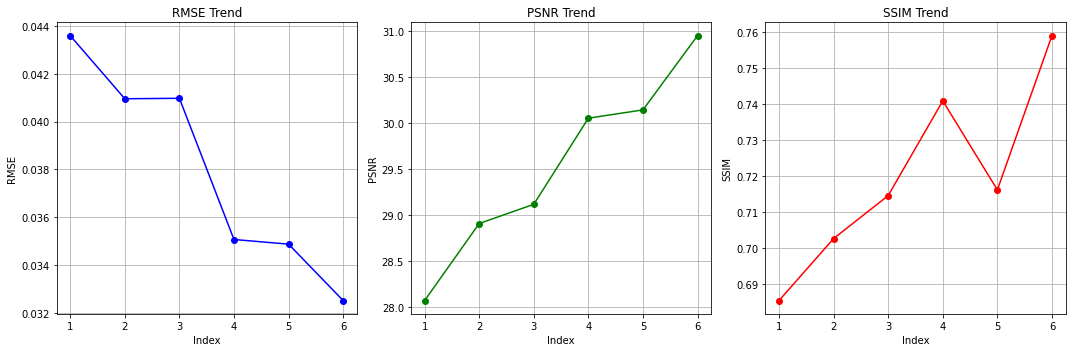

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 그래프 인덱스 (각 값의 순서를 나타냄)
# x_values = np.arange(1, 7)

# # 그래프 그리기
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# # RMSE 그래프
# axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
# axs[0].set_title('RMSE Trend')
# axs[0].set_xlabel('Index')
# axs[0].set_ylabel('RMSE')
# axs[0].grid(True)

# # PSNR 그래프
# axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
# axs[1].set_title('PSNR Trend')
# axs[1].set_xlabel('Index')
# axs[1].set_ylabel('PSNR')
# axs[1].grid(True)

# # SSIM 그래프
# axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
# axs[2].set_title('SSIM Trend')
# axs[2].set_xlabel('Index')
# axs[2].set_ylabel('SSIM')
# axs[2].grid(True)

# # 그래프 레이아웃 조정 및 표시
# plt.tight_layout()
# plt.show()

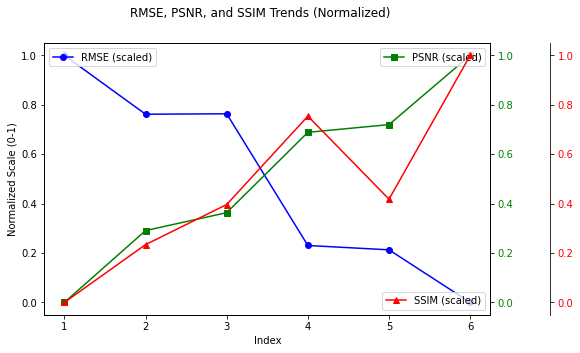

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # 정규화 함수 (min-max scaling)
# def min_max_scale(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))

# # 정규화
# rmse_scaled = min_max_scale(rmse_list)
# psnr_scaled = min_max_scale(psnr_list)
# ssim_scaled = min_max_scale(ssim_list)

# # 그래프 인덱스
# x_values = np.arange(1, len(rmse_list) + 1)

# # 그래프 그리기
# fig, ax1 = plt.subplots(figsize=(8, 5))

# # RMSE (파란색 원)
# ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
# ax1.set_ylabel("Normalized Scale (0-1)", color='black')
# ax1.set_xlabel("Index")
# ax1.tick_params(axis='y', labelcolor='black')

# # PSNR (초록색 사각형, 보조 y축)
# ax2 = ax1.twinx()
# ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
# ax2.tick_params(axis='y', labelcolor='g')

# # SSIM (빨간색 삼각형, 추가 y축)
# ax3 = ax1.twinx()
# ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
# ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
# ax3.tick_params(axis='y', labelcolor='r')

# # 제목 및 범례
# fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
# ax3.legend(loc="lower right")

# # 그래프 표시
# plt.show()

In [ ]:
# # 평균(mean)과 표준편차(sd) 계산
# rmse_mean = np.mean(rmse_list)
# rmse_sd = np.std(rmse_list)

# psnr_mean = np.mean(psnr_list)
# psnr_sd = np.std(psnr_list)

# ssim_mean = np.mean(ssim_list)
# ssim_sd = np.std(ssim_list)

# # 결과를 mean ± sd 형식으로 표현
# rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
# psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
# ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# # 결과 출력
# print(f"RMSE: {rmse_result}")
# print(f"PSNR: {psnr_result}")
# print(f"SSIM: {ssim_result}")

RMSE: 0.0380 ± 0.0040
PSNR: 29.5434 ± 0.9444
SSIM: 0.7199 ± 0.0241


# 최종결과비교

## 특정 epoch

In [ ]:
epoch = 10

In [ ]:
import pandas as pd

# CSV 파일 경로 설정
csv_paths = {
    "base": f"{root}/base/results_{epoch}.csv",
    "channel": f"{root}/attention_channel/results_{epoch}.csv",
    "spatial": f"{root}/attention_spatial/results_{epoch}.csv",
    "moanet": f"{root}/moanet/results_{epoch}.csv"
}

# 각 파일을 읽어와서 데이터프레임으로 저장
df_dict = {}
for name, path in csv_paths.items():
    df = pd.read_csv(path)
    df_dict[name] = df
df_dict

{'base':        RMSE       PSNR      SSIM
 0  0.046955  27.371000  0.676597
 1  0.043945  28.134906  0.688910
 2  0.044556  28.206019  0.694916
 3  0.038896  29.056226  0.717701
 4  0.038351  29.143702  0.691895
 5  0.035719  29.962605  0.739510,
 'channel':        RMSE       PSNR      SSIM
 0  0.046635  27.461906  0.673734
 1  0.044073  28.206451  0.689694
 2  0.044531  28.287235  0.698862
 3  0.038076  29.325519  0.724371
 4  0.037717  29.412435  0.703514
 5  0.035756  30.100435  0.745796,
 'spatial':        RMSE       PSNR      SSIM
 0  0.043425  28.102589  0.684205
 1  0.040999  28.903337  0.701939
 2  0.040919  29.126717  0.711839
 3  0.035002  30.072307  0.738309
 4  0.034874  30.144735  0.714661
 5  0.032634  30.933748  0.758179,
 'moanet':        RMSE       PSNR      SSIM
 0  0.043590  28.073895  0.685536
 1  0.040954  28.911255  0.702734
 2  0.040973  29.120020  0.714661
 3  0.035074  30.056026  0.740951
 4  0.034880  30.146035  0.716251
 5  0.032523  30.953028  0.759038}

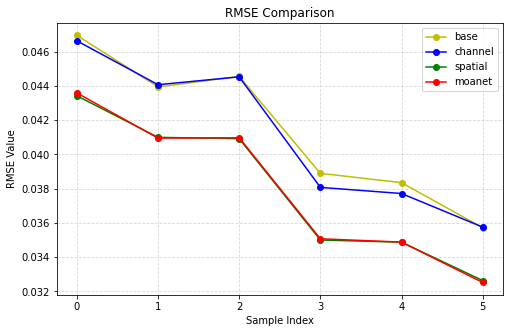

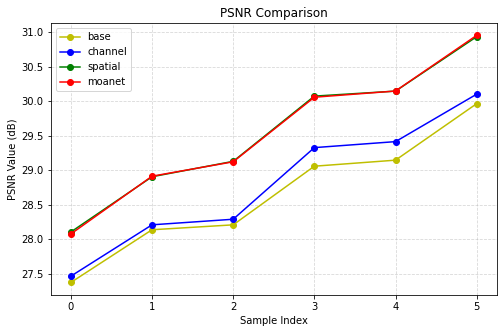

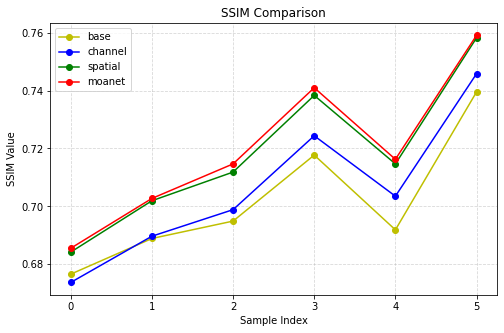

In [217]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 리스트
model_names = ["base", "channel", "spatial", "moanet"]
colors = ["y", "b", "g", "r"]  # 각 모델별 색상 지정

# 그래프 그리는 함수
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))  # 그래프 크기 설정

    for model, color in zip(model_names, colors):
        metric_values = df_dict[model][metric_name].values  # 모델별 해당 지표 값 가져오기
        x_axis = np.arange(len(metric_values))  # X축: 데이터 인덱스
        plt.plot(x_axis, metric_values, marker="o", linestyle="-", color=color, label=model)

    plt.xlabel("Sample Index")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name} Comparison")
    plt.legend()  # 모델 구분을 위한 legend 추가
    plt.grid(True, linestyle="--", alpha=0.5)  # 격자 추가
    plt.show()

# RMSE 그래프
plot_metric("RMSE", "RMSE Value")

# PSNR 그래프
plot_metric("PSNR", "PSNR Value (dB)")

# SSIM 그래프
plot_metric("SSIM", "SSIM Value")

/tmp/ipykernel_1458323/2272622696.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
/tmp/ipykernel_1458323/2272622696.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
/tmp/ipykernel_1458323/2272622696.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전


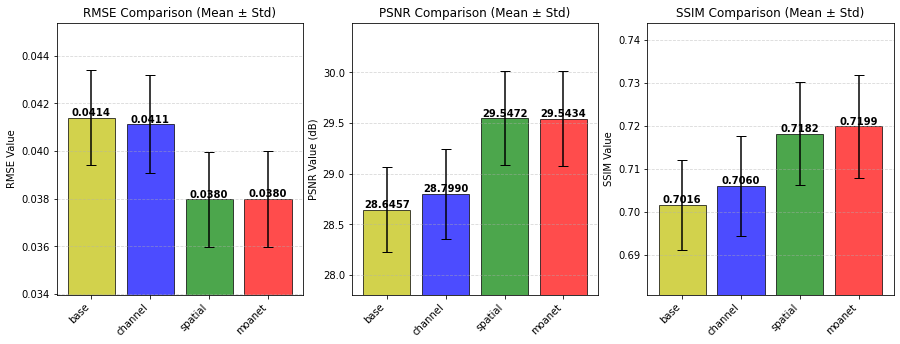

In [220]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 리스트 및 색상 설정
model_names = ["base", "channel", "spatial", "moanet"]
colors = ["y", "b", "g", "r"]  # 각 모델별 색상 지정

# 그래프 그리는 함수 (평균 + 표준편차)
def plot_mean_std(ax, metric_name, ylabel):
    x_labels = model_names  # X축에 모델 이름 표시
    means = []  # 평균값 저장 리스트
    stds = []   # 표준편차 저장 리스트

    for model in model_names:
        metric_values = df_dict[model][metric_name].values  # 해당 모델의 지표 값 가져오기
        means.append(np.mean(metric_values))  # 평균
        stds.append(np.std(metric_values))  # 표준편차

    # 리스트를 NumPy 배열로 변환
    means = np.array(means)
    stds = np.array(stds)

    # y축 범위 설정 (최소/최대값 + 표준편차의 3배)
    ymin = np.min(means-stds)
    ymax = np.max(means+stds)
    ax.set_ylim(ymin, ymax)

    # 막대그래프 (오차 막대 포함)
    bars = ax.bar(x_labels, means, yerr=stds / 2, capsize=5, color=colors, alpha=0.7, edgecolor="black")

    # 막대 위에 평균값 표시
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Comparison (Mean ± Std)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)  # y축 격자 추가

# 1행 3열 그래프 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
plot_mean_std(axes[0], "RMSE", "RMSE Value")

# PSNR 그래프
plot_mean_std(axes[1], "PSNR", "PSNR Value (dB)")

# SSIM 그래프
plot_mean_std(axes[2], "SSIM", "SSIM Value")

# 이미지 저장 (고해상도)
plt.savefig(f"{root}/cmp_att_type.png", dpi=300, bbox_inches='tight')  # 저장 경로 및 해상도 설정
plt.show()


## 모든 epochs

/tmp/ipykernel_1962602/2845809779.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")
/tmp/ipykernel_1962602/2845809779.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")
/tmp/ipykernel_1962602/2845809779.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")


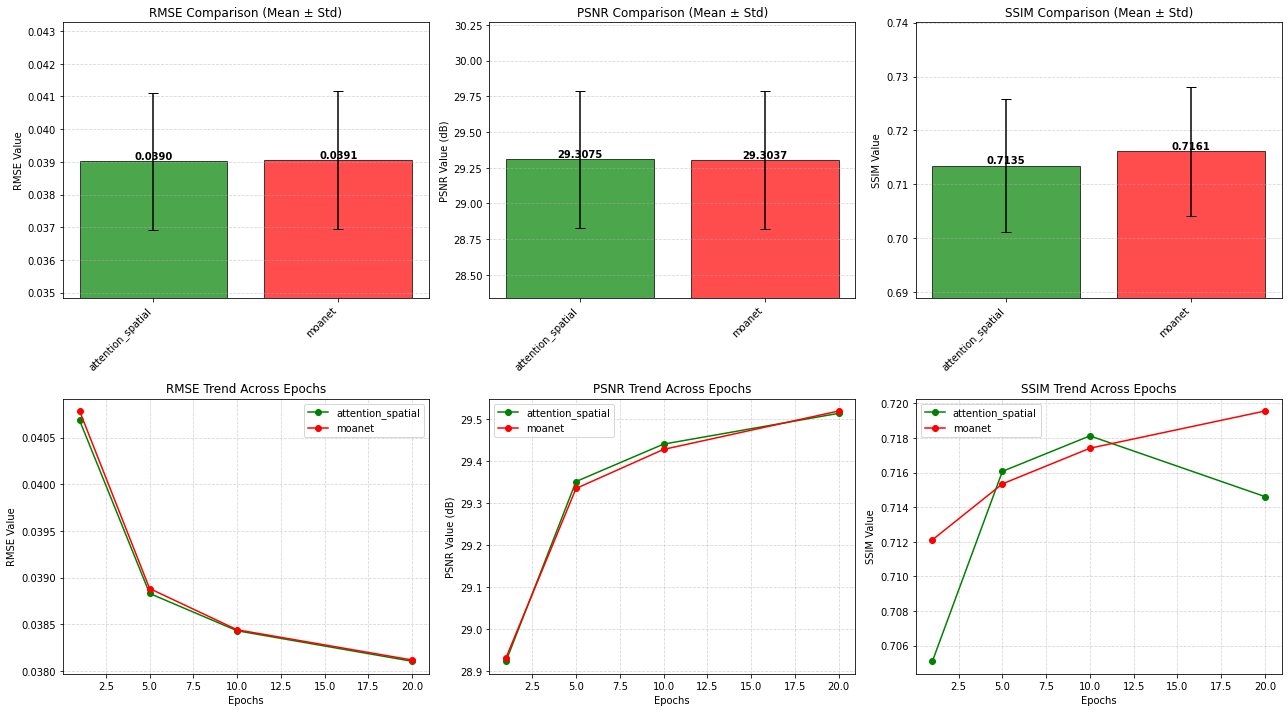

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# 모델 리스트 및 색상 설정
model_names = ["base", "attention_channel", "attention_spatial", "moanet"][2:]
colors = ["y", "b", "g", "r"][2:]  # 각 모델별 색상 지정

# 평가할 epoch 리스트
epochs_list = [1, 5, 10, 20, 30]  # 모든 epoch에 대해 그래프를 그릴 예정

# CSV 파일 경로 설정 (각 모델의 epoch별 파일 불러오기)
csv_paths = {
    model: {epoch: f"{root}/{model}/results_{epoch}.csv" for epoch in epochs_list}
    for model in model_names
}

# 각 파일을 읽어와서 데이터프레임 저장
df_dict = {}
for model, epoch_files in csv_paths.items():
    df_dict[model] = {}
    for epoch, path in epoch_files.items():
        if os.path.exists(path):  # 파일이 존재할 경우만 읽기
            df_dict[model][epoch] = pd.read_csv(path)

# 평균 및 표준편차 그래프 그리는 함수
def plot_mean_std(ax, metric_name, ylabel):
    x_labels = model_names  # X축에 모델 이름 표시
    means = []
    stds = []

    for model in model_names:
        all_values = []
        for epoch in epochs_list:
            if epoch in df_dict[model]:
                all_values.extend(df_dict[model][epoch][metric_name].values)  # 모든 epoch의 값 합치기

        if all_values:
            means.append(np.mean(all_values))
            stds.append(np.std(all_values))
        else:
            means.append(0)
            stds.append(0)

    means = np.array(means)
    stds = np.array(stds)

    # y축 범위 설정 (최소/최대값 + 표준편차의 3배)
    ymin = np.min(means - stds)
    ymax = np.max(means + stds)
    ax.set_ylim(ymin, ymax)

    # 막대그래프 (오차 막대 포함)
    bars = ax.bar(x_labels, means, yerr=stds / 2, capsize=5, color=colors, alpha=0.7, edgecolor="black")

    # 막대 위에 평균값 표시
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Comparison (Mean ± Std)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# Epoch 별 변화 그래프
def plot_epoch_trend(ax, metric_name, ylabel):
    for model, color in zip(model_names, colors):
        means = []
        epochs_available = []
        
        for epoch in epochs_list:
            if epoch in df_dict[model]:
                means.append(df_dict[model][epoch][metric_name].mean())
                epochs_available.append(epoch)
        
        if means:
            ax.plot(epochs_available, means, marker='o', linestyle='-', color=color, label=model)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Trend Across Epochs")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

# 그래프 그리기
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# RMSE 평균 + 표준편차
plot_mean_std(axes[0, 0], "RMSE", "RMSE Value")

# PSNR 평균 + 표준편차
plot_mean_std(axes[0, 1], "PSNR", "PSNR Value (dB)")

# SSIM 평균 + 표준편차
plot_mean_std(axes[0, 2], "SSIM", "SSIM Value")

# RMSE epoch 변화
plot_epoch_trend(axes[1, 0], "RMSE", "RMSE Value")

# PSNR epoch 변화
plot_epoch_trend(axes[1, 1], "PSNR", "PSNR Value (dB)")

# SSIM epoch 변화
plot_epoch_trend(axes[1, 2], "SSIM", "SSIM Value")

# 이미지 저장
plt.tight_layout()
plt.savefig(f"{root}/cmp_epoch_att_type.png", dpi=300, bbox_inches='tight')
plt.show()